# 3. Basic model from scratch

## Prerequisites

  - Install Conda and create environment: see notebook *1. Conda setup*
  - Install Poetry and create configuration: see notebook *2. Poetry setup*

Make sure you select the environment (kernel) *NN* to run this notebook. Also activate it in companion terminal:  
`conda activate NN`

Let's check we have Python 3.9 running:

In [1]:
!python --version

Python 3.9.7


Let's make sure packages and dependencies are installed by Poetry:  
```poetry install```

Let's check our packages and dependencies:

In [2]:
!poetry show --tree

matplotlib 3.5.1 Python plotting package
├── cycler >=0.10
├── fonttools >=4.22.0
├── kiwisolver >=1.0.1
├── numpy >=1.17
├── packaging >=20.0
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pillow >=6.2.0
├── pyparsing >=2.2.1
├── python-dateutil >=2.7
│   └── six >=1.5 
└── setuptools-scm >=4
    ├── packaging >=20.0 
    │   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
    └── tomli >=1.0.0 
numpy 1.22.1 NumPy is the fundamental package for array computing with Python.
pytest 6.2.5 pytest: simple powerful testing with Python
├── atomicwrites >=1.0
├── attrs >=19.2.0
├── colorama *
├── iniconfig *
├── packaging *
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pluggy >=0.12,<2.0
├── py >=1.8.2
└── toml *
torch 1.10.1 Tensors and Dynamic neural networks in Python with strong GPU acceleration
└── typing-extensions *


If we want to update the Conda environment, we can run (in companion terminal):  
```
conda env update --prune -f environment_init.yml
```

If we want to update the Poetry setup, we can run (in companion terminal, making sure NN is activated):  
```
poetry update
```

We can create shortcuts for these actions in a separate **Makefile** (check its contents), which can then be called from a terminal:
```
make conda-udate
make poetry-update
```

## Linear model

Note: This notebook is inspired from https://fullstackdeeplearning.com/spring2021/notebook-1/.

### Generate and visualize data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Let us create and show a dataset of 20 points:

In [4]:
nb_datapoints = 10
input_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

Suppose that we want to approximate the 'true' function \bar{f}(x) = x/2 + 1:


In [5]:
output_dim = 1

weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

y_true = x @ weights_true + bias_true # Matrix multiplication and element-wise addition

Let's inspect all the shapes:

In [6]:
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}')

x: (10, 1), weights: (1, 1), bias: (1,), y_true: (10, 1)


Let's plot our true function:

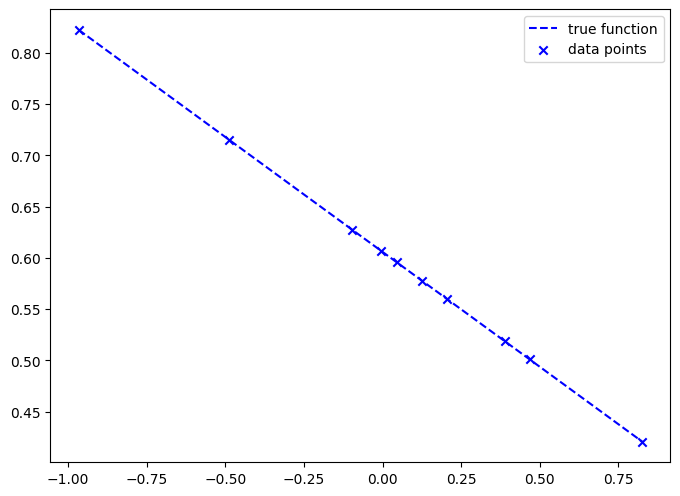

In [7]:
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b--', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.legend()
plt.show()

### Linear model

Let us define the simplest model: one layer, linear, no activation function. This is equivalent to linear regression.

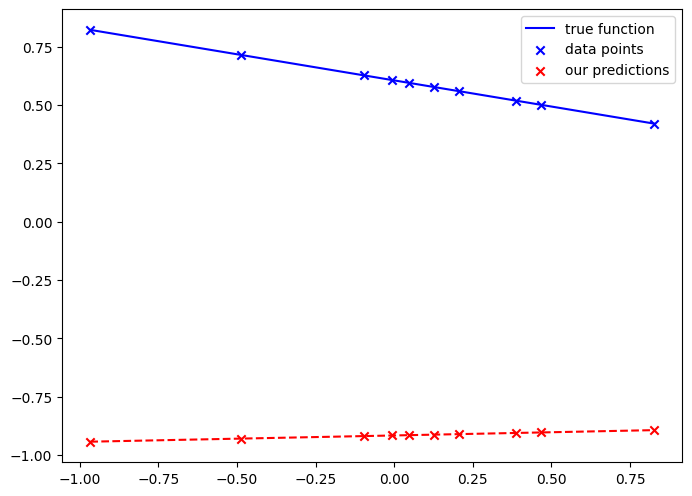

In [8]:
class LinearLayer:
  def __init__(self, input_dim, output_dim):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(1. / input_dim) # Not sure why FSDL had np.sqrt(2. / input_dim)
    # It is best to think of the weights as a matrix acting on the input (given as a line vector) by multiplication *on the right*
    self.bias = np.random.randn(output_dim) * np.sqrt(1. / input_dim) # FSDL initializes them to zero: np.zeros(output_dim)
  
  def __call__(self, x):
    return x @ self.weights + self.bias
  # Mind that the first dim of x corresponds to the number of data points.
  # In numpy, when doing matrix multiplication, if either argument is N-dimensional, N > 2, 
  # then it is treated as a stack of matrices residing in the last two indexes.

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    x = self.x # x has shape (nb_datapoints, input_dim) 
    # previous_grad has shape (nb_datapoints, output_dim)
    self.weights_gradient = x.T @ previous_grad # shape (input_dim, output_dim)
    self.bias_gradient = previous_grad.sum(axis=0) # shape (output_dim,)
    self.x_gradient = previous_grad @ self.weights.T # shape (nb_datapoints, input_dim)
    return self.x_gradient

  def update(self, learning_rate):
    self.weights = self.weights - learning_rate*self.weights_gradient
    self.bias = self.bias - learning_rate*self.bias_gradient
    

linear = LinearLayer(1, 1)
y_pred = linear(x)
figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b-', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
plt.scatter(x.squeeze(-1), y_pred.squeeze(-1), color='r', marker='x', label='our predictions')
plt.legend()
plt.show()

Basic metric: MSE


In [9]:
class MSE:
  def __call__(self, y, y_true):
    # y and y true have shape (nb_datapoints, output_dim)
    return ((y - y_true) ** 2).sum(axis=1).mean(axis=0)

  def gradient(self, y, y_true):
    nb_datapoints = y.shape[0]
    return 2. * (y - y_true) / nb_datapoints # shape (nb_datapoints, output_dim)
    # Note: We divide by |nb_datapoints| to not have to do it during backpropagation

  
metric = MSE()
print(f'Our initial loss is {metric(y_pred, y_true)}')

Our initial loss is 2.2932061912162167


Let's now create our model:

In [10]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(self.x)

    def loss(self, x, y_true):
        return self.metric(self(x), y_true)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

Let's try it! Observe that the loss decreases after one forward and backward pass.

In [11]:

def fbar(x):
  return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (10, 1))
y_true = fbar(x)


linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)

print(f"loss = {model.loss(x, y_true)}")

model.forward(x)
model.backward(y_true, 0.1)
print(f"loss = {model.loss(x, y_true)}")

loss = 0.5694453946018323
loss = 0.3657136204889992


Let's add some bells and whistles:

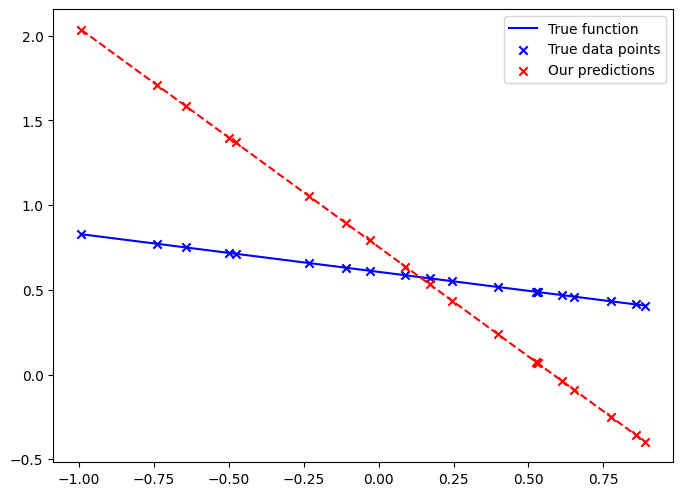

Epoch 1: loss = 0.01855573690625607
Epoch 2: loss = 0.0005981041894067075
Epoch 3: loss = 2.819391303220486e-05
Epoch 4: loss = 2.7242350937032057e-06
Epoch 5: loss = 9.923984380264881e-08
Epoch 6: loss = 2.7936345652224342e-09
Epoch 7: loss = 5.736317335242439e-11
Epoch 8: loss = 4.480696663194184e-12
Epoch 9: loss = 1.6080296841628122e-13
Epoch 10: loss = 1.3127036362548685e-14


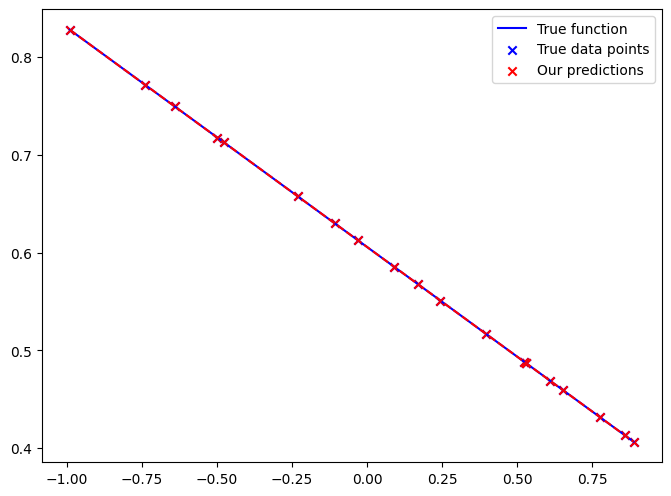

In [13]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(x)

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            seed = np.random.randint(0, 2**(32 - 1) - 1)
            rstate = np.random.RandomState(seed)
            rstate.shuffle(x_training)
            rstate = np.random.RandomState(seed)
            rstate.shuffle(y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        fig = plt.figure(figsize=(8, 6), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], y_true, label='True data points')
        ax.scatter(x[:, 0], x[:, 1], y_pred, label='Our predictions')
        plt.legend()
        plt.show()



def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(10)
model.plot()

Let's try to approximate a non-linear function:

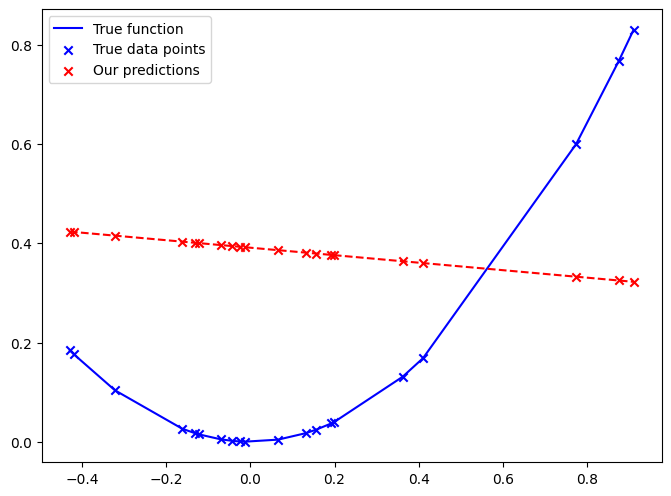

Epoch 1: loss = 0.07778442945956154
Epoch 2: loss = 0.06161285484586108
Epoch 3: loss = 0.052888767844002926
Epoch 4: loss = 0.047391955681959294
Epoch 5: loss = 0.04264953513801276
Epoch 6: loss = 0.039254738702804236
Epoch 7: loss = 0.03642528595488943
Epoch 8: loss = 0.03428314320918674
Epoch 9: loss = 0.03260850382519215
Epoch 10: loss = 0.031197493761511173


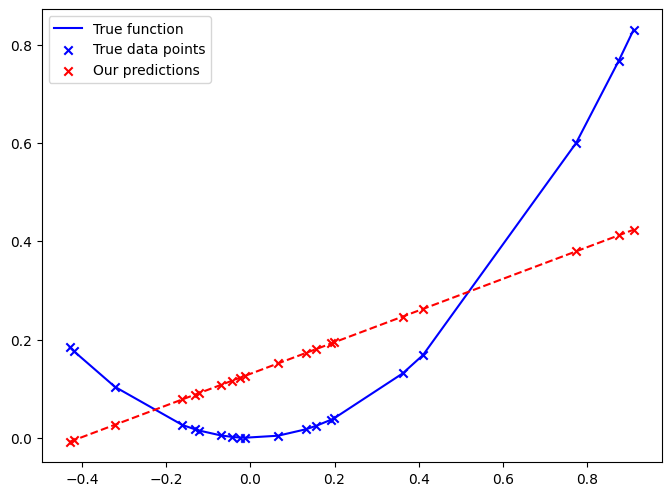

In [15]:
def fbar(x):
    return x ** 2

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(learning_rate=0.1)


model.plot()
model.train(10)
model.plot()

### 2-dimensional inputs work too

(100, 2)
(2, 1)


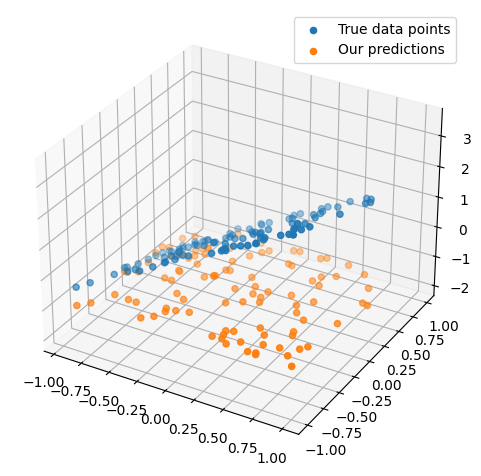

Epoch 1: loss = 1.4246680920735144e-06
Epoch 2: loss = 2.177464411805567e-11
Epoch 3: loss = 1.8117997974044367e-18


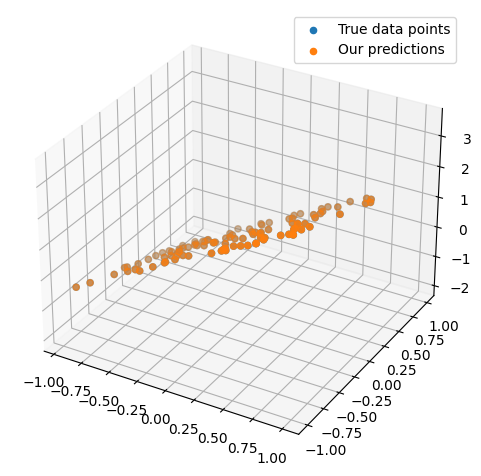

In [16]:

nb_datapoints = 100
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])

print(x.shape)
print(weights_true.shape)

def fbar(x):
  return x @ weights_true + bias_true

y_true = fbar(x)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)

model.plot3d()
model.train(3)
model.plot3d()

(1000, 1)


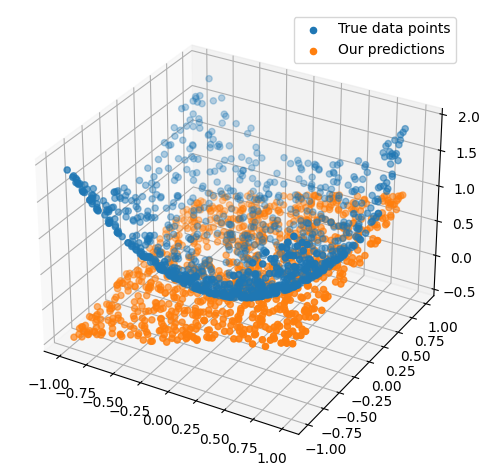

Epoch 1: loss = 0.3143227757195145
Epoch 2: loss = 0.2977943834411714
Epoch 3: loss = 0.21956118616059608
Epoch 4: loss = 0.30918540974851155
Epoch 5: loss = 0.2383261034202904
Epoch 6: loss = 0.26350894916816925
Epoch 7: loss = 0.19512815448888182
Epoch 8: loss = 0.1956372689683629
Epoch 9: loss = 0.283397379153565
Epoch 10: loss = 0.20058240035352373


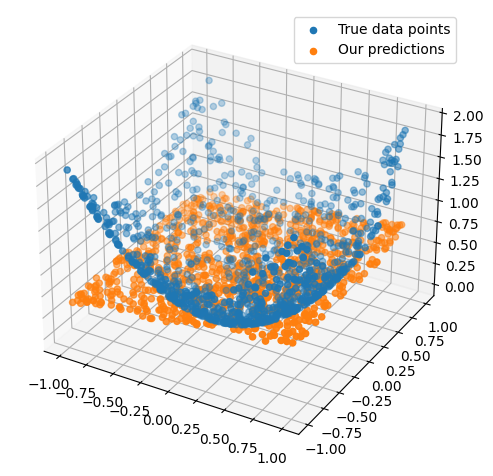

In [17]:
def fbar(x):
  return (x**2).sum(axis=1)[..., None]

nb_datapoints = 1000
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

y_true = fbar(x)
print(y_true.shape)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot3d()
model.train(10)
model.plot3d()

### Add non-linearity: ReLU

In [22]:
class ReluLayer:  
  def __call__(self, x):
    return np.clip(x, 0, None)

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    self.gradient = (self.x > 0) * previous_grad
    return self.gradient

  def update(self, learning_rate):
    return




f = ReluLayer()
x1 = np.random.uniform(-1, 1, (3, 2))
print(x1)
print(f(x1))

[[-0.24157191  0.30805244]
 [ 0.77603765  0.67608011]
 [-0.68160373 -0.0796733 ]]
[[0.         0.30805244]
 [0.77603765 0.67608011]
 [0.         0.        ]]


In [ ]:
class Model:
    def __init__(self, *layers, metric):
        self.layers = layers
        self.metric = metric

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        
        for layer in self.layers:
            x = layer.forward(x)
        return x
        self.y = x

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            seed = np.random.randint(0, 2**(32 - 1) - 1)
            rstate = np.random.RandomState(seed)
            rstate.shuffle(x_training)
            rstate = np.random.RandomState(seed)
            rstate.shuffle(y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        fig = plt.figure(figsize=(8, 6), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], y_true, label='True data points')
        ax.scatter(x[:, 0], x[:, 1], y_pred, label='Our predictions')
        plt.legend()
        plt.show()



def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(20)
model.plot()

### Train our new non-linear model

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 1)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

In [ ]:
# Test just one forward and backward step
loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

In [ ]:
fit(x, y_true, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x))

### Same thing, in PyTorch

In [ ]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x_tensor).detach())

### Same thing, in Tensorflow/Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

plot_3d(x, y_true, model(x))